#  <center>Model ConvLSTM2d</center>

**Predicting rainfall occurrence**

- More than 1mm per day == yes
- 

**Data Structure**

- Time perion (start='2004-03-01 00:00:00', end='2005-08-31 23:00:00' )
- Resample to Daily data
- Normalize data (z-score) according to grid
- Train (95%) and valid (5%)
- Area (latitude=(30, 15),  longitude=slice(85, 95))

**Model Structure**
- ConvLSTM2d model
- Layers 5 and filters (32, 64, 32, 64, 32)
- Used (BatchNormalization) and Dropout(0.1))
- Optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
- loss='mse', metrics='mae'

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
march_2004 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2004\Mar_2004\data_stream-oper_stepType-instant.nc")
march_prep_2004 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2004\Mar_2004\data_stream-oper_stepType-accum.nc")
april_2004 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2004\Apr_2004\data_stream-oper_stepType-instant.nc")
april_prep_2004 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2004\Apr_2004\data_stream-oper_stepType-accum.nc")
may_aug_2004 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2004\May_Aug_2004\data_stream-oper_stepType-instant.nc")
may_aug_prep_2004 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2004\May_Aug_2004\data_stream-oper_stepType-accum.nc")
sep_dec_2004 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2004\Sep_Dec_2004\data_stream-oper_stepType-instant.nc")
sep_dec_prep_2004 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2004\Sep_Dec_2004\data_stream-oper_stepType-accum.nc")
jan_apr_2005 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2005\Jan_Apr_2005\data_stream-oper_stepType-instant.nc")
jan_apr_prep_2005 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2005\Jan_Apr_2005\data_stream-oper_stepType-accum.nc")
may_aug_2005 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2005\May_Aug_2005\data_stream-oper_stepType-instant.nc")
may_aug_prep_2005 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2005\May_Aug_2005\data_stream-oper_stepType-accum.nc")
sep_dec_2005 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2005\Sep_Dec_2005\data_stream-oper_stepType-instant.nc")
sep_dec_prep_2005 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2005\Sep_Dec_2005\data_stream-oper_stepType-accum.nc")
jan_apr_2006 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2006\Jan_Apr_2006\data_stream-oper_stepType-instant.nc")
jan_apr_prep_2006 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2006\Jan_Apr_2006\data_stream-oper_stepType-accum.nc")
may_aug_2006 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2006\May_Aug_2006\data_stream-oper_stepType-instant.nc")
may_aug_prep_2006 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2006\May_Aug_2006\data_stream-oper_stepType-accum.nc")
sep_dec_2006 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2006\Sep_Dec_2006\data_stream-oper_stepType-instant.nc")
sep_dec_prep_2006 = xr.open_dataset(r"D:\Heavy Monsoon\Data\2006\Sep_Dec_2006\data_stream-oper_stepType-accum.nc")

In [3]:
datasets_data = [march_2004, april_2004, may_aug_2004, sep_dec_2004,jan_apr_2005,may_aug_2005,sep_dec_2005,jan_apr_2006,may_aug_2006,sep_dec_2006]
datasets_prep = [march_prep_2004, april_prep_2004, may_aug_prep_2004, sep_dec_prep_2004,jan_apr_prep_2005,may_aug_prep_2005,sep_dec_prep_2005,jan_apr_prep_2006,may_aug_prep_2006,sep_dec_prep_2006]
# Concatenate along valid_time
all_data = xr.concat(datasets_data, dim="valid_time")
all_prep = xr.concat(datasets_prep, dim="valid_time")

In [4]:
all_data

<xarray.Dataset> Size: 7GB
Dimensions:     (valid_time: 24816, latitude: 121, longitude: 113)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 199kB 2004-03-01 ... 2006-12-31T2...
  * latitude    (latitude) float64 968B 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 904B 72.0 72.25 72.5 ... 99.5 99.75 100.0
    expver      (valid_time) <U4 397kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 1GB 287.7 ... 295.4
    msl         (valid_time, latitude, longitude) float32 1GB 1.015e+05 ... 1...
    sst         (valid_time, latitude, longitude) float32 1GB nan nan ... nan
    viwve       (valid_time, latitude, longitude) float32 1GB 7.041 ... 226.7
    viwvn       (valid_time, latitude, longitude) float32 1GB -41.64 ... -19.22
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-02T12:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
all_data = all_data.sel(
    latitude=slice(30, 15),  
    longitude=slice(85, 95)
)
all_prep = all_prep.sel(
    latitude=slice(30, 15),     
    longitude=slice(85, 95)
)

In [6]:
temperature_2m = all_data['t2m']
sea_level_pressure = all_data['msl']
sea_surface_temp = all_data['sst']
eastward_water_vapour_flux = all_data['viwve']
northward_water_vapour_flux = all_data['viwvn']
precipitation = all_prep['tp']

In [7]:
# Replace NaN values in sea_surface_temp with t2m values
sea_surface_temp_filled = sea_surface_temp.fillna(temperature_2m)

In [8]:
# Generate complete hourly time range
full_time_range = pd.date_range(
    start='2004-03-01 00:00:00',
    end='2006-12-31 23:00:00', 
    freq='h'
)

# Regularize ALL variables with forward fill
precipitation_regular = precipitation.reindex(valid_time=full_time_range, method='ffill')
sea_level_pressure_regular = sea_level_pressure.reindex(valid_time=full_time_range, method='ffill')
sea_surface_temp_filled_regular = sea_surface_temp_filled.reindex(valid_time=full_time_range, method='ffill')
eastward_water_vapour_flux_regular = eastward_water_vapour_flux.reindex(valid_time=full_time_range, method='ffill')
northward_water_vapour_flux_regular = northward_water_vapour_flux.reindex(valid_time=full_time_range, method='ffill')

# Print shapes to verify
print("Shapes after regularization:")
print(f"Precipitation: {precipitation_regular.valid_time.shape}")
print(f"Sea level pressure: {sea_level_pressure_regular.valid_time.shape}")
print(f"SST: {sea_surface_temp_filled_regular.valid_time.shape}")
print(f"Eastward flux: {eastward_water_vapour_flux_regular.valid_time.shape}")
print(f"Northward flux: {northward_water_vapour_flux_regular.valid_time.shape}")


# Check if we still have NaN values
print("NaN counts after forward fill reindexing:")
print(f"Precipitation: {precipitation_regular.isnull().sum().item()}")
print(f"Sea level pressure: {sea_level_pressure_regular.isnull().sum().item()}")
print(f"SST: {sea_surface_temp_filled_regular.isnull().sum().item()}")
print(f"Eastward flux: {eastward_water_vapour_flux_regular.isnull().sum().item()}")
print(f"Northward flux: {northward_water_vapour_flux_regular.isnull().sum().item()}")

Shapes after regularization:
Precipitation: (24864,)
Sea level pressure: (24864,)
SST: (24864,)
Eastward flux: (24864,)
Northward flux: (24864,)
NaN counts after forward fill reindexing:
Precipitation: 0
Sea level pressure: 0
SST: 0
Eastward flux: 0
Northward flux: 0


In [9]:
# Resample 
precipitation_1D = precipitation_regular.resample(valid_time='1D').sum()
sea_level_pressure_1D = sea_level_pressure_regular.resample(valid_time='1D').mean()
sea_surface_temp_1D = sea_surface_temp_filled_regular.resample(valid_time='1D').mean()
eastward_water_vapour_flux_1D = eastward_water_vapour_flux_regular.resample(valid_time='1D').mean()
northward_water_vapour_flux_1D = northward_water_vapour_flux_regular.resample(valid_time='1D').mean()

# Check for NaN values in all resampled variables
print("\nNaN counts after regularization and daily resampling:")
print(f"Precipitation: {precipitation_1D.isnull().sum().item()}")
print(f"Sea level pressure: {sea_level_pressure_1D.isnull().sum().item()}")
print(f"SST: {sea_surface_temp_1D.isnull().sum().item()}")
print(f"Eastward flux: {eastward_water_vapour_flux_1D.isnull().sum().item()}")
print(f"Northward flux: {northward_water_vapour_flux_1D.isnull().sum().item()}")



NaN counts after regularization and daily resampling:
Precipitation: 0
Sea level pressure: 0
SST: 0
Eastward flux: 0
Northward flux: 0


In [10]:
# --- Combine all required features into one Dataset ---
ds = xr.Dataset({
    'tp': precipitation_1D * 1000,
    'msl': sea_level_pressure_1D,
    'sst': sea_surface_temp_1D,
    'Qu': eastward_water_vapour_flux_1D,
    'Qv': northward_water_vapour_flux_1D,
})

In [11]:
ds['tp']

<xarray.DataArray 'tp' (valid_time: 1036, latitude: 61, longitude: 41)> Size: 10MB
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         4.1723251e+00, 2.8944016e+00, 2.1820068e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         4.8947334e+00, 1.7066002e+00, 4.4026375e+00],
        [0.0000000e+00, 9.5367432e-04, 6.1988831e-03, ...,
         2.5143623e+00, 6.3662529e+00, 1.2482643e+01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 4.7683716e-04, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         2.3841858e-03, 4.7683716e-04, 4.7683716e-04],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         8.1062317e-03, 2.3841858e-03, 1.4305115e-03]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.4553070e+00, 8.2731247e-01, 5.3310394e-01],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         2.0747185e+00, 6.1273575e-01, 1.1215210e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.1525154e+00, 1.7442703e+00, 3.6554337e+00],
...
        [0.0000000e+00, 2.3841858e-03, 1.7642975e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [8.1062317e-03, 1.1444092e-02, 3.0994415e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.8596649e-02, 3.5762787e-02, 8.3923340e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 1.4305115e-03, ...,
         1.4228821e+00, 4.1151047e-01, 5.8364868e-01],
        [0.0000000e+00, 2.8610229e-03, 9.5367432e-03, ...,
         1.4686584e+00, 2.3078918e-01, 1.5130043e+00],
        [9.5367432e-04, 1.4305115e-02, 6.1988831e-02, ...,
         7.6436996e-01, 1.2574196e+00, 3.1905174e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]], dtype=float32)
Coordinates:
  * latitude    (latitude) float64 488B 30.0 29.75 29.5 ... 15.5 15.25 15.0
  * longitude   (longitude) float64 328B 85.0 85.25 85.5 ... 94.5 94.75 95.0
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 8kB 2004-03-01 ... 2006-12-31

In [12]:
tp = ds['tp'] 

#### Create Binary Target (Rain / No-Rain)

In [13]:
RAIN_THRESHOLD = 1.0 # mm/day

ds['rain_occ'] = (tp > RAIN_THRESHOLD).astype(np.int8)
print(ds['rain_occ'].mean().values) # fraction of rainy days

0.4895505118415954


##### Normalize Inputs (grid-wise z-score)

In [14]:
def zscore_gridwise(da):
    mean = da.mean(dim='valid_time')
    std = da.std(dim='valid_time')
    return (da - mean) / std

ds_scaled = xr.Dataset({
    'tp': zscore_gridwise(ds['tp']),
    'msl': zscore_gridwise(ds['msl']),
    'sst': zscore_gridwise(ds['sst']),
    'Qu': zscore_gridwise(ds['Qu']),
    'Qv': zscore_gridwise(ds['Qv']),
    'rain_occ': ds['rain_occ']
})

In [15]:
print("After fixed normalization:")
for var in ['tp', 'msl', 'sst', 'Qu', 'Qv','rain_occ']:
    nan_count = ds_scaled[var].isnull().sum().item()
    print(f"{var}: {nan_count} NaN values")

After fixed normalization:
tp: 0 NaN values
msl: 0 NaN values
sst: 0 NaN values
Qu: 0 NaN values
Qv: 0 NaN values
rain_occ: 0 NaN values


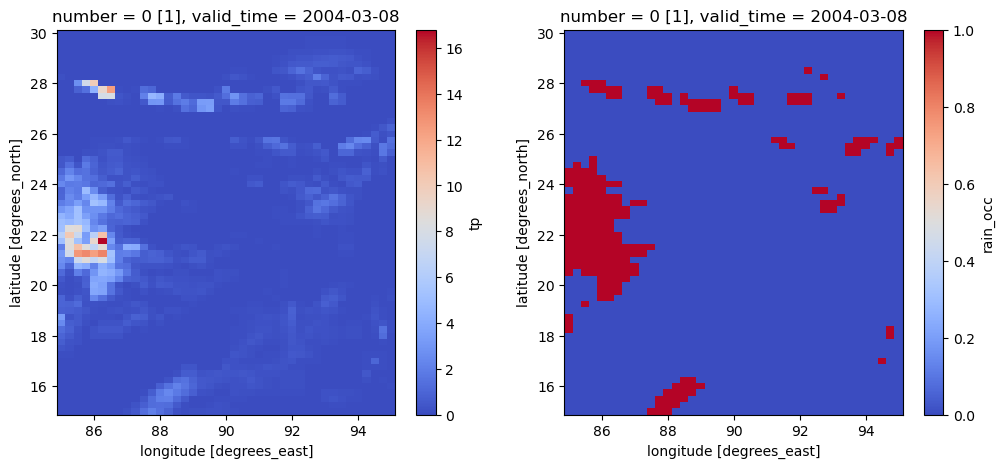

In [16]:
t = 7 # day index to visualize

fig, axs = plt.subplots(1, 2, figsize=(12,5))
ds["tp"].isel(valid_time=t).plot(ax=axs[0], cmap="coolwarm")


ds_scaled["rain_occ"].isel(valid_time=t).plot(ax=axs[1], cmap="coolwarm")

plt.show()


##### Train / Validation Split

In [17]:
time = ds.valid_time
split_idx = int(0.9* len(time))

ds_train = ds_scaled.isel(valid_time=slice(0, split_idx))
ds_val = ds_scaled.isel(valid_time=slice(split_idx, None))

##### Create ConvLSTM Samples

In [18]:
lookback = 15
features =  ['tp', 'msl', 'sst', 'Qu', 'Qv']

def make_samples(ds, target):
    X, y = [], []
    for i in range(len(ds.valid_time) - lookback):
        X.append(
            np.stack(
                [ds[v].isel(valid_time=slice(i, i+lookback)).values for v in features],
                axis = -1
            )
        )
        y.append(ds[target].isel(valid_time=i+lookback).values)
    return np.array(X), np.array(y)

🔵 STAGE 1: CLASSIFICATION
=========================

#### Prepare Classification Data

In [19]:
X_train, y_train = make_samples(ds_train, 'rain_occ')
X_val,   y_val   = make_samples(ds_val,   'rain_occ')

print(X_train.shape, y_train.shape)


(917, 15, 61, 41, 5) (917, 61, 41)


#### ConvLSTM Classification Model

In [20]:
clf = models.Sequential([
    layers.ConvLSTM2D(32, (3,3), padding='same',
                      return_sequences=True,
                      input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(32, (3,3), padding='same',
                      return_sequences=False),
    layers.BatchNormalization(),

    layers.Conv2D(1, (1,1), activation='sigmoid')
])

clf.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]
)

clf.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 15, 61, 41, 32)    42752     
                                                                 
 batch_normalization (BatchN  (None, 15, 61, 41, 32)   128       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 61, 41, 32)        73856     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 41, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d (Conv2D)             (None, 61, 41, 1)         33        
                                                                 
Total params: 116,897
Trainable params: 116,769
Non-trai

##### Train Classifier

In [21]:
clf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
29/29 [==============================] - 24s 613ms/step - loss: 0.4458 - accuracy: 0.8064 - AUC: 0.8764 - val_loss: 0.5986 - val_accuracy: 0.7939 - val_AUC: 0.7572
Epoch 2/20
29/29 [==============================] - 17s 601ms/step - loss: 0.4109 - accuracy: 0.8237 - AUC: 0.8945 - val_loss: 0.5893 - val_accuracy: 0.7946 - val_AUC: 0.7655
Epoch 3/20
29/29 [==============================] - 17s 602ms/step - loss: 0.3923 - accuracy: 0.8352 - AUC: 0.9040 - val_loss: 0.5708 - val_accuracy: 0.7972 - val_AUC: 0.7747
Epoch 4/20
29/29 [==============================] - 18s 609ms/step - loss: 0.3746 - accuracy: 0.8427 - AUC: 0.9130 - val_loss: 0.5565 - val_accuracy: 0.7983 - val_AUC: 0.7802
Epoch 5/20
29/29 [==============================] - 19s 657ms/step - loss: 0.3675 - accuracy: 0.8451 - AUC: 0.9166 - val_loss: 0.5582 - val_accuracy: 0.8002 - val_AUC: 0.7823
Epoch 6/20
29/29 [==============================] - 19s 657ms/step - loss: 0.3630 - accuracy: 0.8488 - AUC: 0.9185 - val_loss

##### Classification Evaluation

3/3 [==============================] - 2s 227ms/step


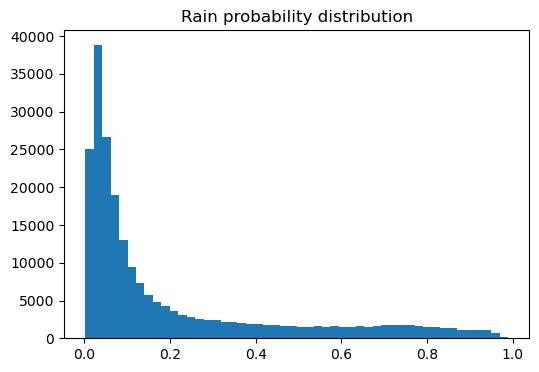

In [22]:
y_prob = clf.predict(X_val)
y_pred = (y_prob > 0.5).astype(int)

plt.figure(figsize=(6,4))
plt.hist(y_prob.flatten(), bins=50)
plt.title("Rain probability distribution")
plt.show()


🟢 STAGE 2: REGRESSION
=========================

##### Regression Target (log-rainfall, rainy days only)

In [23]:
ds['tp_log'] = np.log1p(ds['tp'])
ds['tp_log'] = ds['tp_log'].where(ds['tp'] > RAIN_THRESHOLD, 0.0)
ds_scaled['tp_log'] = zscore_gridwise(ds['tp_log'])

time = ds.valid_time
split_idx = int(0.9* len(time))

ds_train = ds_scaled.isel(valid_time=slice(0, split_idx))
ds_val = ds_scaled.isel(valid_time=slice(split_idx, None))
Xr_train, yr_train = make_samples(ds_train, 'tp_log')
Xr_val,   yr_val   = make_samples(ds_val,   'tp_log')

##### ConvLSTM Regression Model

In [24]:
reg = models.Sequential([
    layers.ConvLSTM2D(32, (3,3), padding='same',
                      return_sequences=True,
                      input_shape=Xr_train.shape[1:]),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(32, (3,3), padding='same',
                      return_sequences=False),
    layers.BatchNormalization(),

    layers.Conv2D(1, (1,1), activation='linear')
])

reg.compile(
    optimizer=Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

reg.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 15, 61, 41, 32)    42752     
                                                                 
 batch_normalization_2 (Batc  (None, 15, 61, 41, 32)   128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 61, 41, 32)        73856     
                                                                 
 batch_normalization_3 (Batc  (None, 61, 41, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 41, 1)         33        
                                                                 
Total params: 116,897
Trainable params: 116,769
Non-tr

##### Train Regression Model

In [25]:
reg.fit(
    Xr_train, yr_train,
    validation_data=(Xr_val, yr_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
29/29 [==============================] - 30s 746ms/step - loss: 1.1527 - mae: 0.8037 - val_loss: 0.6036 - val_mae: 0.7202
Epoch 2/20
29/29 [==============================] - 21s 708ms/step - loss: 0.6285 - mae: 0.5871 - val_loss: 0.5695 - val_mae: 0.6970
Epoch 3/20
29/29 [==============================] - 21s 712ms/step - loss: 0.5657 - mae: 0.5520 - val_loss: 0.5391 - val_mae: 0.6749
Epoch 4/20
29/29 [==============================] - 21s 713ms/step - loss: 0.5240 - mae: 0.5282 - val_loss: 0.5327 - val_mae: 0.6698
Epoch 5/20
29/29 [==============================] - 21s 719ms/step - loss: 0.5037 - mae: 0.5183 - val_loss: 0.4659 - val_mae: 0.6141
Epoch 6/20
29/29 [==============================] - 21s 709ms/step - loss: 0.4861 - mae: 0.5078 - val_loss: 0.4673 - val_mae: 0.6159
Epoch 7/20
29/29 [==============================] - 21s 707ms/step - loss: 0.4622 - mae: 0.4946 - val_loss: 0.4303 - val_mae: 0.5814
Epoch 8/20
29/29 [==============================] - 21s 707ms/step - 

FINAL PREDICTION
=========================

##### Combine Classification + Regression

In [26]:
rain_prob = clf.predict(X_val)
rain_mask = rain_prob > 0.5

tp_log_pred = reg.predict(Xr_val)

tp_log_pred = tp_log_pred * rain_mask
tp_pred_mm = np.expm1(tp_log_pred)

3/3 [==============================] - 1s 217ms/step


##### COMPARISON & PLOTS

###### Map Comparison

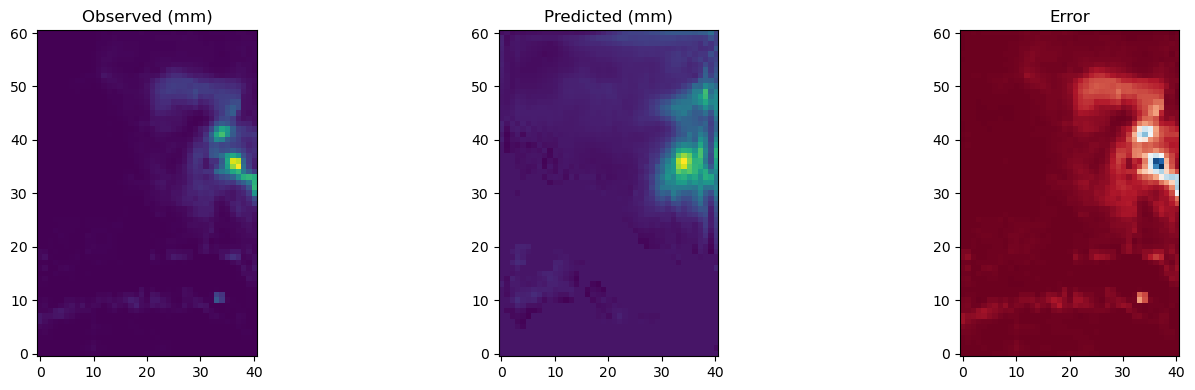

In [29]:
t = 5

obs = ds['tp'].isel(valid_time=split_idx + lookback + t).values
pred = tp_pred_mm[t, :, :, 0]

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].imshow(obs, origin='lower')
axs[0].set_title("Observed (mm)")

axs[1].imshow(pred, origin='lower')
axs[1].set_title("Predicted (mm)")

axs[2].imshow(pred - obs, origin='lower', cmap='RdBu_r')
axs[2].set_title("Error")

plt.tight_layout()
plt.show()

###### Time-Series Comparison (Area Mean)

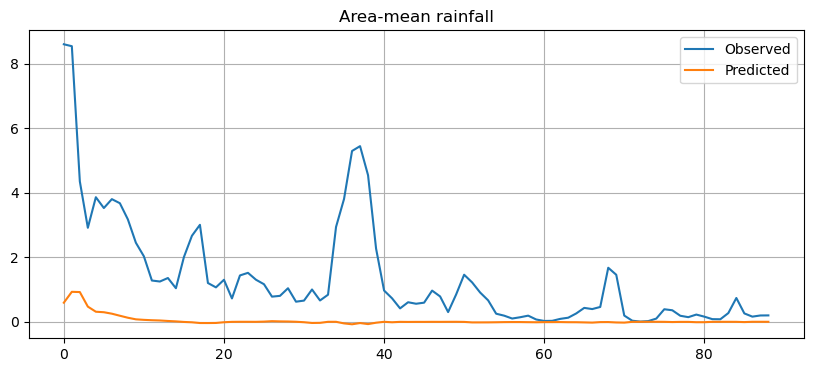

In [28]:
obs_mean = ds['tp'].isel(
    valid_time=slice(split_idx+lookback, split_idx+lookback+len(tp_pred_mm))
).mean(dim=['latitude','longitude'])

pred_mean = tp_pred_mm.mean(axis=(1,2,3))

plt.figure(figsize=(10,4))
plt.plot(obs_mean, label='Observed')
plt.plot(pred_mean, label='Predicted')
plt.legend()
plt.title("Area-mean rainfall")
plt.grid()
plt.show()
